In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time 
import time
import warnings
from collections import deque
import psutil
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json' 

TARGET_MODULATIONS = ['OOK','4ASK','8ASK','BPSK', 
                      'QPSK', '8PSK', '16QAM',
                     '64QAM','OQPSK'
                     ]
#TARGET_MODULATIONS = ['OOK','4ASK','BPSK', 'QPSK', '8PSK','16QAM','GMSK']
BATCH_SIZE = 512 # adjust to my laptop 
#LEARNING_RATE = 0.003 
NUM_EPOCHS = 300 
NUM_WORKERS = 0 #Temporary check it  

INPUT_CHANNELS = 2 
SEQUENCE_LENGTH = 1024 
NUM_CLASSES = len(TARGET_MODULATIONS) # adjust this to 

patience = 25
# TRAIN_RATIO = 0.7 
# VALID_RATIO = 0.2 
# TEST_RATIO = 0.1 

nf_train = int(BATCH_SIZE * 0.7)
nf_valid = int(BATCH_SIZE * 0.3)
nf_test  = BATCH_SIZE - nf_train - nf_valid

print("📋 Training Parameters:")
print(f"  Batch size: {BATCH_SIZE}")
#print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

📋 Training Parameters:
  Batch size: 512
  Epochs: 300


In [23]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.7, # training 70 %
                  valid_proportion=0.3, # validation 20 %
                  test_proportion=0.0, # testing 10 % 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []                                   

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [24]:
class RadioMLIQDataset(Dataset):
    """Dataset class for RadioML18 data formatted for CNNIQModel dual-branch architecture.
    
    Loads RadioML18 HDF5 data and returns separate I and Q tensors in 2D format
    suitable for CNNIQModel's separate branch processing.
    """
    
    def __init__(self, mode: str, use_fft: bool = False, seed: int = 48):
        """Initialize RadioMLIQDataset.
        
        Args:
            mode: Dataset split mode ('train', 'valid', or 'test').
            use_fft: Whether to apply FFT transformation to signals.
            seed: Random seed for dataset splitting.
            
        Raises:
            FileNotFoundError: If HDF5 or JSON files cannot be found.
            ValueError: If mode is not valid or data dimensions are incompatible.
        """
        super(RadioMLIQDataset, self).__init__()
        
        # Configuration (you'll need to define these constants)
        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft
        self.mode = mode
        
        # Validate mode
        if mode not in ['train', 'valid', 'test']:
            raise ValueError(f"Mode must be 'train', 'valid', or 'test', got '{mode}'")
        
        # Load data files
        try:
            self.hdf5_file = h5py.File(self.file_path, 'r')
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Error loading data files: {e}")
        except Exception as e:
            print(f"Error loading file: {e}")
            raise e
        
        # Load raw data
        self.X = self.hdf5_file['X']
        self.Y = np.argmax(self.hdf5_file['Y'], axis=1)
        self.Z = self.hdf5_file['Z'][:, 0]
        
       
        num_mods = len(self.target_modulations)   
        num_snrs = 26         
        
        train_proportion = (num_mods * num_snrs * nf_train) / self.X.shape[0]
        valid_proportion = (num_mods * num_snrs * nf_valid) / self.X.shape[0]
        test_proportion  = (num_mods * num_snrs * nf_test ) / self.X.shape[0]
        
        self.target_snrs = np.unique(self.Z)
        
        # Split dataset
        self.X_data, self.Y_data, self.Z_data = dataset_split(
            data=self.X,
            modulations_classes=self.modulation_classes,
            modulations=self.Y,
            snrs=self.Z,
            mode=mode,
            train_proportion=train_proportion,
            valid_proportion=valid_proportion,
            test_proportion=test_proportion,
            target_modulations=self.target_modulations,
            target_snrs=self.target_snrs,
            seed=seed
        )
        
        # Apply I/Q swap correction for AMC compatibility
        # print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
        self.X_data = self.X_data[:, :, [0, 1]]
        # print(f"✅ I/Q channels corrected for real-world compatibility")
        
        # Validate signal length for 2D reshaping
        signal_length = self.X_data.shape[1]
        if signal_length != 1024:
            raise ValueError(f"Expected signal length 1024 for 32x32 reshape, got {signal_length}")

        import math
        
        L = signal_length
        H = int(math.floor(math.sqrt(L)))
        while L % H != 0:
            H -= 1
        W = L // H
        
        self.H, self.W = H, W
        print(f"🔧 Signals will be reshaped to ({H}, {W}) for sequence length {L}")
        print(f"✅ Aspect ratio: {W/H:.2f}, Total elements preserved: {H*W} = {L}")
        
        if self.use_fft:
            print("Dataset configured to use FFT as input")
        
        # Store dataset statistics
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
        print(f"RadioMLIQDataset {mode}: {self.num_data} samples, "
              f"{self.num_lbl} classes, {self.num_snr} SNR levels")
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset.
        
        Returns:
            Number of samples.
        """
        return self.X_data.shape[0]
    

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= self.num_data:
            raise IndexError(f"Index {idx} out of range for dataset of size {self.num_data}")

        x_raw = self.X_data[idx]       # shape: (L, 2)
        y     = int(self.Y_data[idx])
        z     = float(self.Z_data[idx])

        # Convert to tensor
        x = torch.from_numpy(x_raw).float().transpose(0, 1)  # shape: (2, L)

        if self.use_fft:
            # Combine to complex signal
            complex_sig = torch.complex(x[0], x[1])  # shape: (L,)
            fft_res     = torch.fft.fft(complex_sig)  # shape: (L,)

            # Convert to real-valued 2D (L × 2) matrix: real | imag
            x_fft = torch.stack([torch.real(fft_res), torch.imag(fft_res)], dim=1)  # shape: (L, 2)

            # Reshape to 2D: (1, H, W) each for real and imag
            x_real_2d = x_fft[:, 0].view(1, self.H, self.W)
            x_imag_2d = x_fft[:, 1].view(1, self.H, self.W)

            return x_real_2d, x_imag_2d, y, z

        else:
            # Non-FFT path (amplitude/phase domain)
            i_signal = x[0]  # shape: (L,)
            q_signal = x[1]

            amplitude = torch.sqrt(i_signal**2 + q_signal**2)
            phase     = torch.atan2(q_signal, i_signal)

            i_2d = amplitude.view(1, self.H, self.W)
            q_2d = phase.view(1, self.H, self.W)

            return i_2d, q_2d, y, z

    def get_signal_stats(self):
        """Compute basic stats over a sample of signals."""
        sample_indices = np.random.choice(self.num_data, min(1000, self.num_data), replace=False)
        i_vals, q_vals = [], []
        for idx in sample_indices:
            i2d, q2d, _, _ = self[idx]
            i_vals.append(i2d.flatten())
            q_vals.append(q2d.flatten())
        i_all = torch.cat(i_vals)
        q_all = torch.cat(q_vals)
        return {
            'i_mean': i_all.mean().item(),
            'i_std':  i_all.std().item(),
            'q_mean': q_all.mean().item(),
            'q_std':  q_all.std().item(),
            'shape':  (1, self.H, self.W),
            'num_samples': self.num_data
        }

    def close(self):
        if hasattr(self, 'hdf5_file'):
            self.hdf5_file.close()

    def __del__(self):
        self.close()

In [25]:
# Model 1: Standard CNN-LSTM
try:
    from CNN_LSTM_IQ import create_enhanced_CNNLSTMIQModel
    model_standard = create_enhanced_CNNLSTMIQModel(n_labels=NUM_CLASSES, dropout_rate=0.2).to(device)
    print("✅ Successfully built Standard CNN-LSTM Model")
except Exception as e:
    print(f"⚠️ Could not build Standard Model: {e}")

# Model 2: Parallel CNN-LSTM
try:
    from CNN_LSTM_IQ_Parallel import create_diagram_iq_model
    model_parallel = create_diagram_iq_model(n_labels=NUM_CLASSES, dropout_rate=0.2).to(device)
    print("✅ Successfully built Parallel CNN-LSTM Model")
except Exception as e:
    print(f"⚠️ Could not build Parallel Model: {e}")

✅ Successfully built Standard CNN-LSTM Model
✅ Successfully built Parallel CNN-LSTM Model


In [26]:
from torchinfo import summary 
summary(model_standard) 

Layer (type:depth-idx)                   Param #
CNNLSTMIQModel                           --
├─CNNLSTMBranch: 1-1                     --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─Conv2d: 2-3                       36,928
│    └─BatchNorm2d: 2-4                  128
│    └─Conv2d: 2-5                       73,856
│    └─BatchNorm2d: 2-6                  256
│    └─Conv2d: 2-7                       147,584
│    └─BatchNorm2d: 2-8                  256
│    └─MaxPool2d: 2-9                    --
│    └─LeakyReLU: 2-10                   --
│    └─Dropout2d: 2-11                   --
│    └─LSTM: 2-12                        92,000
│    └─LSTM: 2-13                        30,400
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      51
│    └─AdaptiveAvgPool2d: 2-16           --
├─CNNLSTMBranch: 1-2                     --
│    └─Conv2d: 2-17                      640
│    └─BatchNorm2d: 2-18                 128

In [27]:
summary(model_parallel) 

Layer (type:depth-idx)                   Param #
DiagramIQModel                           --
├─DiagramModel: 1-1                      --
│    └─CNN_1: 2-1                        --
│    │    └─Conv2d: 3-1                  640
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  73,856
│    │    └─BatchNorm2d: 3-4             256
│    │    └─MaxPool2d: 3-5               --
│    │    └─LeakyReLU: 3-6               --
│    │    └─Dropout2d: 3-7               --
│    │    └─AdaptiveAvgPool2d: 3-8       --
│    └─CNN_2: 2-2                        --
│    │    └─Conv2d: 3-9                  640
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 73,856
│    │    └─BatchNorm2d: 3-12            256
│    │    └─MaxPool2d: 3-13              --
│    │    └─Conv2d: 3-14                 295,168
│    │    └─BatchNorm2d: 3-15            512
│    │    └─Conv2d: 3-16                 590,080
│    │    └─BatchNorm2d: 3-17            512
│

In [28]:
# Optimizers for both models
optimizer_standard = optim.AdamW(
    model_standard.parameters(), 
    lr=0.0015,
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

optimizer_parallel = optim.AdamW(
    model_parallel.parameters(), 
    lr=0.0015,
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

# Schedulers for both models
scheduler_standard = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_standard, T_0=20, T_mult=2, eta_min=1e-6
)

scheduler_parallel = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_parallel, T_0=20, T_mult=2, eta_min=1e-6
)

# Scalers for mixed precision
scaler_standard = GradScaler()
scaler_parallel = GradScaler()


In [29]:
# Count parameters for both models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

standard_params = count_parameters(model_standard)
parallel_params = count_parameters(model_parallel)

In [30]:
# Shared training components
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

# Optimizers for both models
optimizer_standard = optim.AdamW(
    model_standard.parameters(), 
    lr=0.0015,
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

optimizer_parallel = optim.AdamW(
    model_parallel.parameters(), 
    lr=0.0015,
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

# Schedulers for both models
scheduler_standard = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_standard, T_0=20, T_mult=2, eta_min=1e-6
)

scheduler_parallel = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_parallel, T_0=20, T_mult=2, eta_min=1e-6
)

# Scalers for mixed precision
scaler_standard = GradScaler()

In [31]:
# --- Data Loaders ---
print("\n📂 Loading datasets...")
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    pin_memory=True, num_workers=0, persistent_workers=False
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    pin_memory=True, num_workers=0, persistent_workers=False
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")


📂 Loading datasets...
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 31356 samples, 9 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset valid: 13338 samples, 9 classes, 26 SNR levels
Train dataset size: 31356
Validation dataset size: 13338


In [42]:
# --- Training Metrics Storage ---
metrics = {
    'standard': {
        'train_losses': [], 'valid_losses': [], 
        'train_accuracies': [], 'valid_accuracies': [],
        'training_times': [], 'best_accuracy': 0.0,
        'final_predictions': [], 'final_true_labels': []
    },
    'parallel': {
        'train_losses': [], 'valid_losses': [], 
        'train_accuracies': [], 'valid_accuracies': [],
        'training_times': [], 'best_accuracy': 0.0,
        'final_predictions': [], 'final_true_labels': []
    }
}

In [43]:
# Early stopping
patience_counters = {'standard': 0, 'parallel': 0}
best_models = {'standard': None, 'parallel': None}

In [44]:
def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    """Train one epoch and return metrics"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for i_inputs, q_inputs, labels, _ in train_loader:
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(i_inputs, q_inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy, epoch_time

def validate_epoch(model, valid_loader, criterion, device):
    """Validate one epoch and return metrics"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in valid_loader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy, predictions, true_labels

In [14]:
# --- Training Loop ---
print("\n🎯 Starting comparative training...")
print("=" * 80)

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress"):
    epoch_start = time.time()
    
    # Train both models
    train_loss_std, train_acc_std, train_time_std = train_epoch(
        model_standard, train_loader, optimizer_standard, criterion, scaler_standard, device
    )
    
    train_loss_par, train_acc_par, train_time_par = train_epoch(
        model_parallel, train_loader, optimizer_parallel, criterion, scaler_parallel, device
    )
    
    # Validate both models
    valid_loss_std, valid_acc_std, pred_std, true_std = validate_epoch(
        model_standard, valid_loader, criterion, device
    )
    
    valid_loss_par, valid_acc_par, pred_par, true_par = validate_epoch(
        model_parallel, valid_loader, criterion, device
    )
    
    # Update metrics
    metrics['standard']['train_losses'].append(train_loss_std)
    metrics['standard']['train_accuracies'].append(train_acc_std)
    metrics['standard']['valid_losses'].append(valid_loss_std)
    metrics['standard']['valid_accuracies'].append(valid_acc_std)
    metrics['standard']['training_times'].append(train_time_std)
    
    metrics['parallel']['train_losses'].append(train_loss_par)
    metrics['parallel']['train_accuracies'].append(train_acc_par)
    metrics['parallel']['valid_losses'].append(valid_loss_par)
    metrics['parallel']['valid_accuracies'].append(valid_acc_par)
    metrics['parallel']['training_times'].append(train_time_par)
    
    # Update schedulers
    scheduler_standard.step()
    scheduler_parallel.step()
    
    # Check for best models and early stopping
    if valid_acc_std > metrics['standard']['best_accuracy']:
        metrics['standard']['best_accuracy'] = valid_acc_std
        metrics['standard']['final_predictions'] = pred_std
        metrics['standard']['final_true_labels'] = true_std
        best_models['standard'] = model_standard.state_dict().copy()
        patience_counters['standard'] = 0
    else:
        patience_counters['standard'] += 1
    
    if valid_acc_par > metrics['parallel']['best_accuracy']:
        metrics['parallel']['best_accuracy'] = valid_acc_par
        metrics['parallel']['final_predictions'] = pred_par
        metrics['parallel']['final_true_labels'] = true_par
        best_models['parallel'] = model_parallel.state_dict().copy()
        patience_counters['parallel'] = 0
    else:
        patience_counters['parallel'] += 1
    
    # Print epoch results
    if (epoch + 1) % 5 == 0:
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}:")
        print(f"Standard  - Train: {train_acc_std:.2f}% | Valid: {valid_acc_std:.2f}% | Time: {train_time_std:.2f}s")
        print(f"Parallel  - Train: {train_acc_par:.2f}% | Valid: {valid_acc_par:.2f}% | Time: {train_time_par:.2f}s")
    
    # Early stopping check
    if min(patience_counters.values()) >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("\n🎉 Training Complete!")
print(f"Standard Model Best Accuracy: {metrics['standard']['best_accuracy']:.2f}%")
print(f"Parallel Model Best Accuracy: {metrics['parallel']['best_accuracy']:.2f}%")


🎯 Starting comparative training...


Training Progress:   2%|▏         | 5/300 [01:24<1:22:33, 16.79s/it]


Epoch 5/300:
Standard  - Train: 53.59% | Valid: 54.75% | Time: 5.01s
Parallel  - Train: 55.27% | Valid: 57.89% | Time: 9.29s


Training Progress:   3%|▎         | 10/300 [02:47<1:20:37, 16.68s/it]


Epoch 10/300:
Standard  - Train: 58.63% | Valid: 55.29% | Time: 4.90s
Parallel  - Train: 58.75% | Valid: 60.16% | Time: 9.35s


Training Progress:   5%|▌         | 15/300 [04:11<1:19:28, 16.73s/it]


Epoch 15/300:
Standard  - Train: 60.95% | Valid: 62.30% | Time: 4.92s
Parallel  - Train: 60.95% | Valid: 62.36% | Time: 9.31s


Training Progress:   7%|▋         | 20/300 [05:34<1:17:45, 16.66s/it]


Epoch 20/300:
Standard  - Train: 61.44% | Valid: 62.48% | Time: 4.97s
Parallel  - Train: 61.73% | Valid: 62.37% | Time: 9.15s


Training Progress:   8%|▊         | 25/300 [06:57<1:15:50, 16.55s/it]


Epoch 25/300:
Standard  - Train: 60.64% | Valid: 58.64% | Time: 4.92s
Parallel  - Train: 60.98% | Valid: 62.66% | Time: 9.28s


Training Progress:  10%|█         | 30/300 [08:20<1:14:37, 16.58s/it]


Epoch 30/300:
Standard  - Train: 62.56% | Valid: 62.45% | Time: 4.96s
Parallel  - Train: 61.77% | Valid: 62.78% | Time: 9.25s


Training Progress:  12%|█▏        | 35/300 [09:47<1:18:59, 17.89s/it]


Epoch 35/300:
Standard  - Train: 63.85% | Valid: 63.25% | Time: 5.93s
Parallel  - Train: 63.40% | Valid: 63.59% | Time: 11.20s


Training Progress:  13%|█▎        | 40/300 [11:36<1:31:55, 21.22s/it]


Epoch 40/300:
Standard  - Train: 64.96% | Valid: 61.13% | Time: 6.83s
Parallel  - Train: 64.39% | Valid: 63.99% | Time: 11.09s


Training Progress:  15%|█▌        | 45/300 [13:19<1:24:36, 19.91s/it]


Epoch 45/300:
Standard  - Train: 66.07% | Valid: 64.33% | Time: 4.88s
Parallel  - Train: 65.59% | Valid: 65.04% | Time: 9.29s


Training Progress:  17%|█▋        | 50/300 [15:06<1:29:11, 21.41s/it]


Epoch 50/300:
Standard  - Train: 67.45% | Valid: 64.10% | Time: 7.06s
Parallel  - Train: 66.34% | Valid: 65.40% | Time: 11.12s


Training Progress:  18%|█▊        | 55/300 [16:44<1:19:25, 19.45s/it]


Epoch 55/300:
Standard  - Train: 68.26% | Valid: 65.26% | Time: 4.97s
Parallel  - Train: 66.75% | Valid: 65.52% | Time: 10.73s


Training Progress:  20%|██        | 60/300 [18:30<1:23:36, 20.90s/it]


Epoch 60/300:
Standard  - Train: 68.37% | Valid: 65.11% | Time: 6.41s
Parallel  - Train: 66.99% | Valid: 65.85% | Time: 11.57s


Training Progress:  22%|██▏       | 65/300 [20:18<1:22:35, 21.09s/it]


Epoch 65/300:
Standard  - Train: 66.48% | Valid: 63.91% | Time: 6.59s
Parallel  - Train: 64.95% | Valid: 64.91% | Time: 10.63s


Training Progress:  23%|██▎       | 70/300 [21:41<1:06:21, 17.31s/it]


Epoch 70/300:
Standard  - Train: 67.37% | Valid: 64.66% | Time: 4.85s
Parallel  - Train: 66.07% | Valid: 64.65% | Time: 9.19s


Training Progress:  25%|██▌       | 75/300 [23:03<1:02:28, 16.66s/it]


Epoch 75/300:
Standard  - Train: 68.33% | Valid: 63.83% | Time: 4.96s
Parallel  - Train: 66.38% | Valid: 65.65% | Time: 9.20s


Training Progress:  27%|██▋       | 80/300 [24:26<1:00:37, 16.53s/it]


Epoch 80/300:
Standard  - Train: 69.10% | Valid: 63.54% | Time: 4.86s
Parallel  - Train: 66.90% | Valid: 65.07% | Time: 9.24s


Training Progress:  27%|██▋       | 82/300 [25:15<1:07:10, 18.49s/it]


Early stopping at epoch 83

🎉 Training Complete!
Standard Model Best Accuracy: 65.35%
Parallel Model Best Accuracy: 65.94%


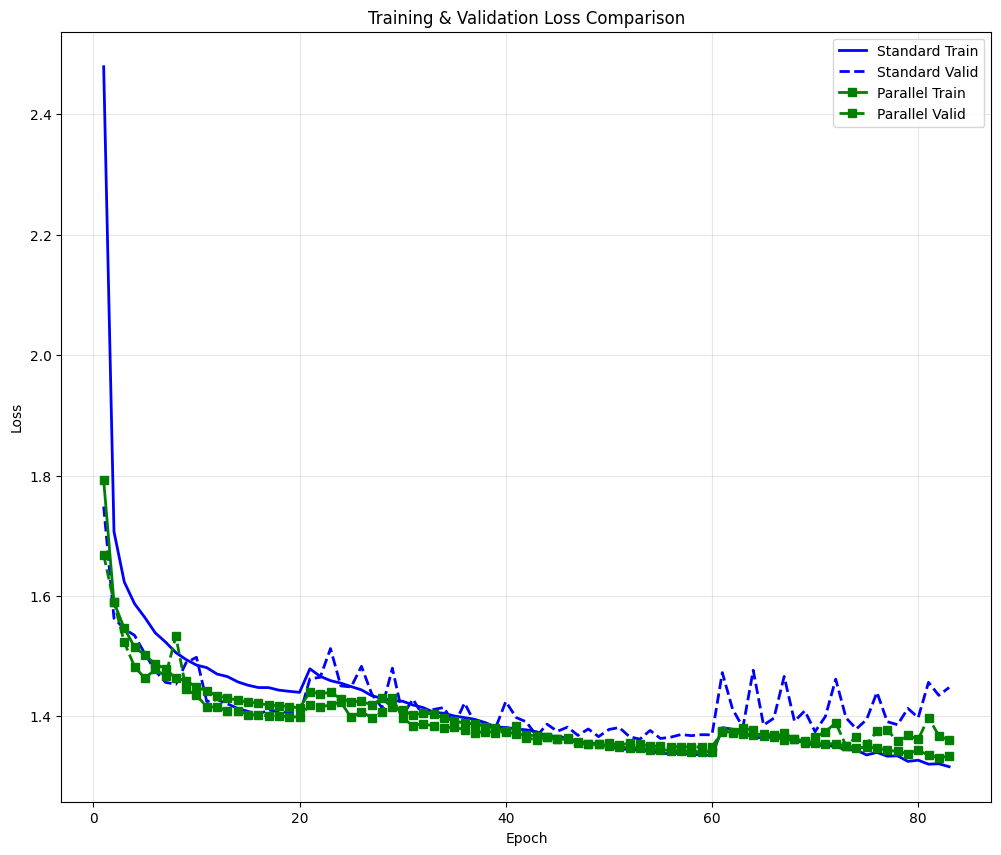

In [15]:
plt.figure(figsize=(12, 10), dpi=100)
epochs = range(1, len(metrics['standard']['train_losses']) + 1)
plt.plot(epochs, metrics['standard']['train_losses'], 'b-', label='Standard Train', linewidth=2)
plt.plot(epochs, metrics['standard']['valid_losses'], 'b--', label='Standard Valid', linewidth=2)
plt.plot(epochs, metrics['parallel']['train_losses'], 'r-', label='Parallel Train', linewidth=2, marker = 's', color = 'green')
plt.plot(epochs, metrics['parallel']['valid_losses'], 'r--', label='Parallel Valid', linewidth=2,marker = 's', color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

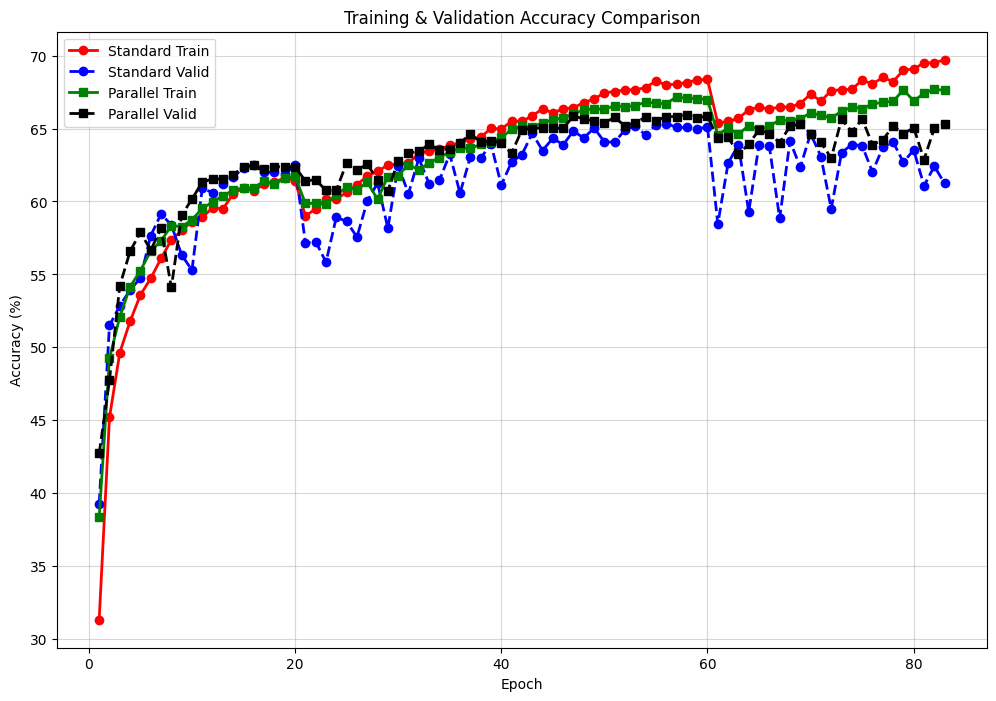

In [16]:
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(epochs, metrics['standard']['train_accuracies'], 'b-', label='Standard Train', linewidth=2,color = 'red',marker = 'o')
plt.plot(epochs, metrics['standard']['valid_accuracies'], 'b--', label='Standard Valid', linewidth=2,color = 'blue', marker = 'o')
plt.plot(epochs, metrics['parallel']['train_accuracies'], 'r-', label='Parallel Train', linewidth=2,color = 'green', marker = 's')
plt.plot(epochs, metrics['parallel']['valid_accuracies'], 'r--', label='Parallel Valid', linewidth=2, color = 'black', marker = 's')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.5)

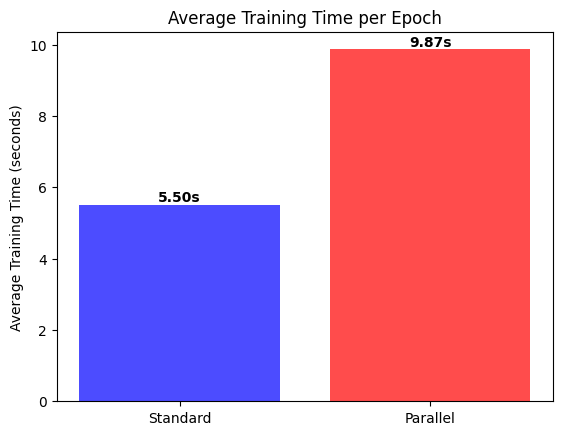

In [17]:
    avg_time_std = np.mean(metrics['standard']['training_times'])
    avg_time_par = np.mean(metrics['parallel']['training_times'])
    models = ['Standard', 'Parallel']
    times = [avg_time_std, avg_time_par]
    colors = ['blue', 'red']
    bars = plt.bar(models, times, color=colors, alpha=0.7)
    plt.ylabel('Average Training Time (seconds)')
    plt.title('Average Training Time per Epoch')
    for bar, time in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{time:.2f}s', ha='center', va='bottom', fontweight='bold')

Text(0.5, 1.0, 'Model Performance Summary')

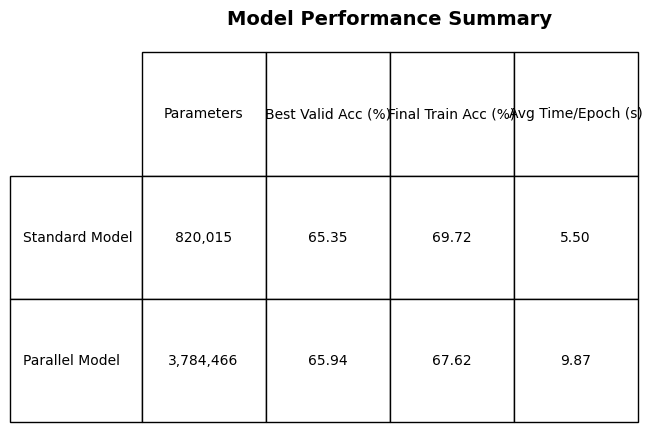

In [18]:
    performance_data = {
        'Metric': ['Parameters', 'Best Valid Acc (%)', 'Final Train Acc (%)', 'Avg Time/Epoch (s)'],
        'Standard': [
            f"{standard_params:,}",
            f"{metrics['standard']['best_accuracy']:.2f}",
            f"{metrics['standard']['train_accuracies'][-1]:.2f}",
            f"{avg_time_std:.2f}"
        ],
        'Parallel': [
            f"{parallel_params:,}",
            f"{metrics['parallel']['best_accuracy']:.2f}",
            f"{metrics['parallel']['train_accuracies'][-1]:.2f}",
            f"{avg_time_par:.2f}"
        ]
    }
    
    # Create table
    plt.axis('off')
    table = plt.table(cellText=[performance_data['Standard'], performance_data['Parallel']],
                     rowLabels=['Standard Model', 'Parallel Model'],
                     colLabels=performance_data['Metric'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.title('Model Performance Summary', pad=20, fontsize=14, fontweight='bold')

Text(50.722222222222214, 0.5, 'Actual')

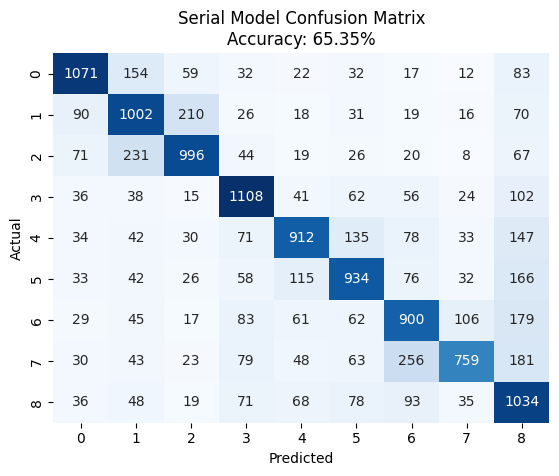

In [19]:
    cm_std = confusion_matrix(metrics['standard']['final_true_labels'], 
                             metrics['standard']['final_predictions'])
    sns.heatmap(cm_std, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Serial Model Confusion Matrix\nAccuracy: {metrics["standard"]["best_accuracy"]:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

Text(50.722222222222214, 0.5, 'Actual')

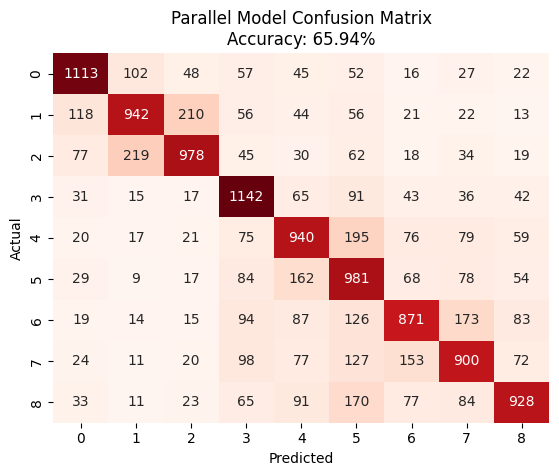

In [20]:
    cm_par = confusion_matrix(metrics['parallel']['final_true_labels'], 
                             metrics['parallel']['final_predictions'])
    sns.heatmap(cm_par, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.title(f'Parallel Model Confusion Matrix\nAccuracy: {metrics["parallel"]["best_accuracy"]:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

### **Heatmap Accuracy Over SNR level on Each Type Modulation**

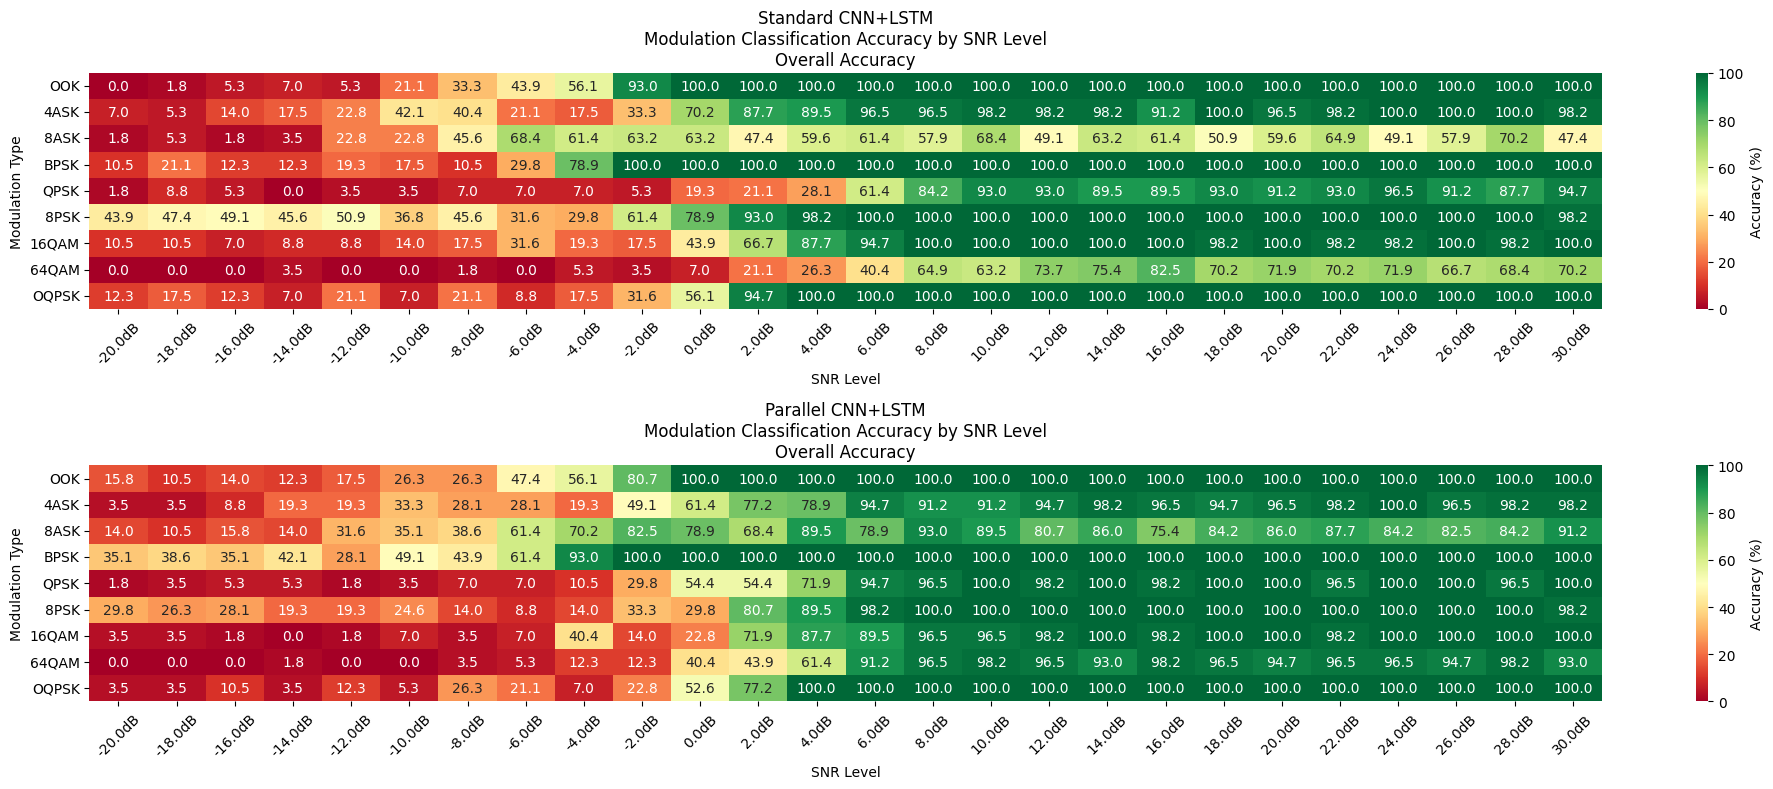

In [21]:
# --- Per-Modulation Accuracy Heatmap for 2 Models ---
def plot_modulation_snr_accuracy_heatmap_comparison(model1, model2, model1_name, model2_name, dataloader, device, target_modulations):
    
    models = {model1_name: model1, model2_name: model2}
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(2, 1, figsize=(20, 8))
    
    for idx, (model_name, model) in enumerate(models.items()):
        model.eval()
        all_predictions = []
        all_true_labels = []
        all_snrs = []
        
        with torch.no_grad():
            for i_inputs, q_inputs, labels, snrs in dataloader:
                i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(i_inputs, q_inputs)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_snrs.extend(snrs.numpy())
        
        predictions_df = pd.DataFrame({
            'true_label': all_true_labels,
            'predicted_label': all_predictions,
            'snr': all_snrs
        })
        
        unique_snrs = sorted(predictions_df['snr'].unique())
        accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
        
        for i, mod in enumerate(target_modulations):
            for j, snr in enumerate(unique_snrs):
                subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
                if len(subset) > 0:
                    accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                    accuracy_matrix[i, j] = accuracy * 100
        
        # Calculate overall accuracy for title
        overall_accuracy = (np.array(all_true_labels) == np.array(all_predictions)).mean() * 100
        
        # Create heatmap for current model
        sns.heatmap(accuracy_matrix, 
                    xticklabels=[f'{snr}dB' for snr in unique_snrs],
                    yticklabels=target_modulations,
                    annot=True, 
                    fmt='.1f', 
                    cmap='RdYlGn',
                    vmin=0, 
                    vmax=100,
                    cbar_kws={'label': 'Accuracy (%)'},
                    ax=axes[idx])
        
        axes[idx].set_title(f'{model_name} CNN+LSTM\nModulation Classification Accuracy by SNR Level\nOverall Accuracy')
        axes[idx].set_xlabel('SNR Level')
        axes[idx].set_ylabel('Modulation Type')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_heatmap_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function with your 2 models
plot_modulation_snr_accuracy_heatmap_comparison(
    model_standard, 
    model_parallel, 
    'Standard', 
    'Parallel', 
    valid_loader, 
    device, 
    TARGET_MODULATIONS
)

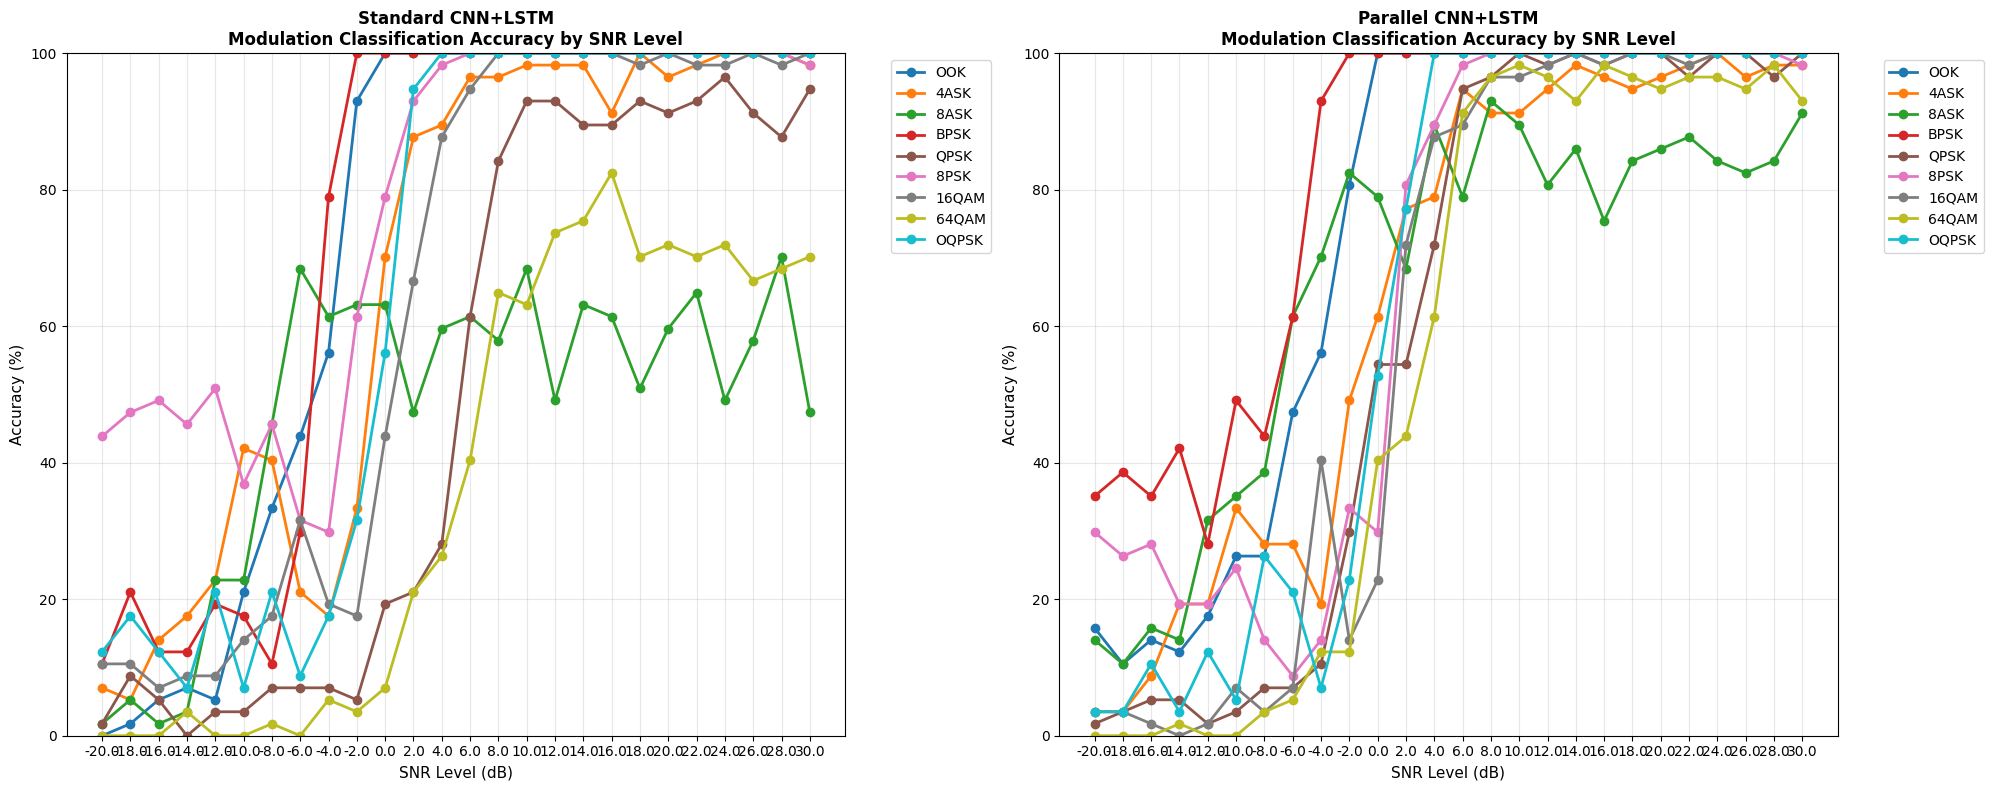

In [22]:
# --- Per-Modulation Accuracy Line Plot for 2 Models ---
def plot_modulation_snr_accuracy_lines_comparison(model1, model2, model1_name, model2_name, dataloader, device, target_modulations):
    
    models = {model1_name: model1, model2_name: model2}
    
    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Color palette for different modulations
    colors = plt.cm.tab10(np.linspace(0, 1, len(target_modulations)))
    
    for idx, (model_name, model) in enumerate(models.items()):
        model.eval()
        all_predictions = []
        all_true_labels = []
        all_snrs = []
        
        with torch.no_grad():
            for i_inputs, q_inputs, labels, snrs in dataloader:
                i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(i_inputs, q_inputs)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_snrs.extend(snrs.numpy())
        
        predictions_df = pd.DataFrame({
            'true_label': all_true_labels,
            'predicted_label': all_predictions,
            'snr': all_snrs
        })
        
        unique_snrs = sorted(predictions_df['snr'].unique())
        
        # Plot line for each modulation type
        for i, mod in enumerate(target_modulations):
            accuracies = []
            for snr in unique_snrs:
                subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
                if len(subset) > 0:
                    accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                    accuracies.append(accuracy * 100)
                else:
                    accuracies.append(0)
            
            # Plot line for this modulation
            axes[idx].plot(unique_snrs, accuracies, 
                          marker='o', linewidth=2, markersize=6,
                          color=colors[i], label=mod)
        
        # Calculate overall accuracy for title
        overall_accuracy = (np.array(all_true_labels) == np.array(all_predictions)).mean() * 100
        
        # Customize subplot
        axes[idx].set_title(f'{model_name} CNN+LSTM\nModulation Classification Accuracy by SNR Level', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('SNR Level (dB)', fontsize=11)
        axes[idx].set_ylabel('Accuracy (%)', fontsize=11)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[idx].set_ylim(0, 100)
        
        # Set x-axis ticks
        axes[idx].set_xticks(unique_snrs)
        axes[idx].set_xticklabels([f'{snr}' for snr in unique_snrs])
    
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_lines_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Alternative version: Overlay both models in single plot
def plot_modulation_snr_accuracy_lines_overlay(model1, model2, model1_name, model2_name, dataloader, device, target_modulations):
    
    models = {model1_name: model1, model2_name: model2}
    model_data = {}
    
    # Create single figure
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    # Color palette for different modulations
    colors = plt.cm.tab10(np.linspace(0, 1, len(target_modulations)))
    
    # Process data for both models
    for model_name, model in models.items():
        model.eval()
        all_predictions = []
        all_true_labels = []
        all_snrs = []
        
        with torch.no_grad():
            for i_inputs, q_inputs, labels, snrs in dataloader:
                i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(i_inputs, q_inputs)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_snrs.extend(snrs.numpy())
        
        predictions_df = pd.DataFrame({
            'true_label': all_true_labels,
            'predicted_label': all_predictions,
            'snr': all_snrs
        })
        
        model_data[model_name] = {
            'predictions_df': predictions_df,
            'overall_accuracy': (np.array(all_true_labels) == np.array(all_predictions)).mean() * 100
        }
    
    unique_snrs = sorted(model_data[model1_name]['predictions_df']['snr'].unique())
    
    # Plot lines for each modulation and model
    for i, mod in enumerate(target_modulations):
        for j, (model_name, data) in enumerate(model_data.items()):
            predictions_df = data['predictions_df']
            accuracies = []
            
            for snr in unique_snrs:
                subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
                if len(subset) > 0:
                    accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                    accuracies.append(accuracy * 100)
                else:
                    accuracies.append(0)
            
            # Different line styles for different models
            linestyle = '-' if j == 0 else '--'
            marker = 'o' if j == 0 else 's'
            
            # Plot line for this modulation and model
            ax.plot(unique_snrs, accuracies, 
                   marker=marker, linewidth=2, markersize=6,
                   color=colors[i], linestyle=linestyle,
                   label=f'{mod} ({model_name})')
    
    # Customize plot
    ax.set_title('Modulation Classification Accuracy by SNR Level\nComparison Between Models', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('SNR Level (dB)', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(0, 100)
    
    # Set x-axis ticks
    ax.set_xticks(unique_snrs)
    ax.set_xticklabels([f'{snr}' for snr in unique_snrs])
    
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_lines_overlay.png', dpi=300, bbox_inches='tight')
    plt.show()
    
plot_modulation_snr_accuracy_lines_comparison(
    model_standard, 
    model_parallel, 
    'Standard', 
    'Parallel', 
    valid_loader, 
    device, 
    TARGET_MODULATIONS
)